# **Import Libraries**

In [2]:
!pip3 install hazm
!pip3 install cleantext
!pip install transformers
!pip install --upgrade accelerate
!pip install -U sentence-transformers
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 371.7/371.7 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 23.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 49.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.7/227.7 kB 19.2 MB/s eta 0:00:00
  Created wheel for flashtext: filename=flashtext-2.7-py2.py3-none-any.whl size=9296 sha256=babd251887a4ee6b9248d46138e66a279843de616791c61c73dec14716e8b724
  Stored in directory: /root/.cache/pip/wheels/bc/be/39/c37ad168eb2ff644c9685f52554440372129450f0b8ed203dd
Successfully built flashtext
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 9.3 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=8787a10813d23ad89bd3e036d95d543ddd3831150b638d0b9725a56798d98433
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.0 MB/s eta 0:00:00


In [36]:
from torch.utils.data import DataLoader
from torch.nn.utils import prune
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import shuffle
from cleantext import clean
from transformers import AutoConfig, AutoTokenizer, AutoModel, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset, load_metric
from torch.nn import CrossEntropyLoss
import seaborn as sns
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import hazm
import copy
import torch
import torch.nn as nn
import random

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Dataset Loading**

In [8]:
train_data = pd.read_csv('./drive/MyDrive/HW5/Q2/Train-word.csv', sep='\t')
val_data = pd.read_csv('./drive/MyDrive/HW5/Q2/Val-word.csv', sep='\t')
test_data = pd.read_csv('./drive/MyDrive/HW5/Q2/Test-word.csv', sep='\t')

In [9]:
train_data

,premise,hypothesis,label
0,اولین انتقال و نفوذ طبیعی فرهنگ و تمدن اسلامی ...,نخستین انتقال و نفوذ طبیعی فرهنگ و تمدن اسلامی...,e
1,اولین انتقال و نفوذ طبیعی فرهنگ و تمدن اسلامی ...,کانون های جغرافیایی مصر، اندلس و شام، نخستین ر...,c
2,اولین انتقال و نفوذ طبیعی فرهنگ و تمدن اسلامی ...,سیسیل بعد از اسپانیا بزرگ ترین کانونی بود که ه...,n
3,ویژگی های هنر عصر اموی: ۱- تلفیقی بودن ۲- بازن...,نقاشی های تزئینی و تندیس های بی‌کیفیت، یکی از ...,e
4,ویژگی های هنر عصر اموی: ۱- تلفیقی بودن ۲- بازن...,با کیفیت بودن تندیس های دوره اموی، یکی از ویژگ...,c
...,...,...,...
7261,قانون اساسی جمهوری اسلامی ایران در سال ۱۳۵۸ تو...,تعداد فصول قانون اساسی ۱۴ و تعداد اصول آن ۱۷۷ ...,e
7262,قانون اساسی جمهوری اسلامی ایران در سال ۱۳۵۸ تو...,قانون اساسی دارای ۲۵ فصل و ۱۷۵ اصل می باشد.,c
7263,قانون اساسی جمهوری اسلامی ایران در سال ۱۳۵۸ تو...,در ۲۴ آبان ۵۸ کار تدوین قانون اساسی به پایان ر...,n
7264,محاصره اقتصادی پیامبر (ص) و یارانش که در سال ه...,حضرت محمد (ص) و یارانش از ششمین سال بعثت تا هش...,c


# **Dataset Pre-Processing**

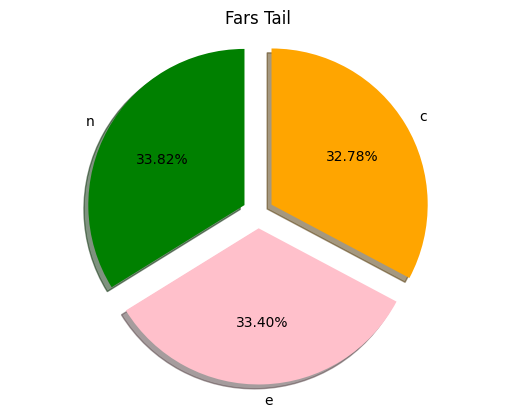

In [10]:
labels = list(sorted(train_data['label'].unique()))
(train_data["label"].value_counts() + val_data["label"].value_counts() + test_data["label"].value_counts())
labels= ['n', 'e', 'c']
colors=['green', 'pink', 'orange']
sizes= [(train_data["label"].value_counts() + val_data["label"].value_counts() + test_data["label"].value_counts())[0],\
        (train_data["label"].value_counts() + val_data["label"].value_counts() + test_data["label"].value_counts())[1], \
        (train_data["label"].value_counts() + val_data["label"].value_counts() + test_data["label"].value_counts())[2]]

plt.pie(sizes,labels=labels, colors=colors, startangle=90, shadow=True,explode=(0.1, 0.1, 0.1), autopct='%1.2f%%')
plt.title('Fars Tail')
plt.axis('equal')
plt.show()

In [11]:
# print data information
print('data information')
print(train_data.info(), '\n')

# print missing values information
print('missing values stats')
print(train_data.isnull().sum(), '\n')

# print some missing values
print('some missing values')
print(train_data[train_data['label'].isnull()].iloc[:5], '\n')

data information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7266 entries, 0 to 7265
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   premise     7266 non-null   object
 1   hypothesis  7266 non-null   object
 2   label       7266 non-null   object
dtypes: object(3)
memory usage: 170.4+ KB
None 

missing values stats
premise       0
hypothesis    0
label         0
dtype: int64 

some missing values
Empty DataFrame
Columns: [premise, hypothesis, label]
Index: [] 



In [12]:
# print data information
print('data information')
print(val_data.info(), '\n')

# print missing values information
print('missing values stats')
print(val_data.isnull().sum(), '\n')

# print some missing values
print('some missing values')
print(val_data[val_data['label'].isnull()].iloc[:5], '\n')

data information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1537 entries, 0 to 1536
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   premise     1537 non-null   object
 1   hypothesis  1537 non-null   object
 2   label       1537 non-null   object
dtypes: object(3)
memory usage: 36.1+ KB
None 

missing values stats
premise       0
hypothesis    0
label         0
dtype: int64 

some missing values
Empty DataFrame
Columns: [premise, hypothesis, label]
Index: [] 



In [13]:
# print data information
print('data information')
print(test_data.info(), '\n')

# print missing values information
print('missing values stats')
print(test_data.isnull().sum(), '\n')

# print some missing values
print('some missing values')
print(test_data[test_data['label'].isnull()].iloc[:5], '\n')

data information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1564 entries, 0 to 1563
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   premise           1564 non-null   object
 1   hypothesis        1564 non-null   object
 2   label             1564 non-null   object
 3   hard(hypothesis)  1564 non-null   int64 
 4   hard(overlap)     1564 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 61.2+ KB
None 

missing values stats
premise             0
hypothesis          0
label               0
hard(hypothesis)    0
hard(overlap)       0
dtype: int64 

some missing values
Empty DataFrame
Columns: [premise, hypothesis, label, hard(hypothesis), hard(overlap)]
Index: [] 



In [14]:
# calculate the length of premises based on their words
train_data['premise_len_by_words'] = train_data['premise'].apply(lambda t: len(hazm.word_tokenize(t)))
# calculate the length of hypothesis based on their words
train_data['hypothesis_len_by_words'] = train_data['hypothesis'].apply(lambda t: len(hazm.word_tokenize(t)))

min_max_len = train_data['premise_len_by_words'].min(), train_data['premise_len_by_words'].max()
print("Train Premise: ", f'Min: {min_max_len[0]} \tMax: {min_max_len[1]}')
min_max_len = train_data['hypothesis_len_by_words'].min(), train_data['hypothesis_len_by_words'].max()
print("Train Hypothesis: ", f'Min: {min_max_len[0]} \tMax: {min_max_len[1]}')

Train Premise:  Min: 9 	Max: 132
Train Hypothesis:  Min: 5 	Max: 55


In [15]:
# calculate the length of premises based on their words
val_data['premise_len_by_words'] = val_data['premise'].apply(lambda t: len(hazm.word_tokenize(t)))
# calculate the length of hypothesis based on their words
val_data['hypothesis_len_by_words'] = val_data['hypothesis'].apply(lambda t: len(hazm.word_tokenize(t)))

min_max_len = val_data['premise_len_by_words'].min(), val_data['premise_len_by_words'].max()
print("Val Premise: ", f'Min: {min_max_len[0]} \tMax: {min_max_len[1]}')
min_max_len = val_data['hypothesis_len_by_words'].min(), val_data['hypothesis_len_by_words'].max()
print("Val Hypothesis: ", f'Min: {min_max_len[0]} \tMax: {min_max_len[1]}')

Val Premise:  Min: 8 	Max: 100
Val Hypothesis:  Min: 5 	Max: 43


In [16]:
# calculate the length of premises based on their words
test_data['premise_len_by_words'] = test_data['premise'].apply(lambda t: len(hazm.word_tokenize(t)))
# calculate the length of hypothesis based on their words
test_data['hypothesis_len_by_words'] = test_data['hypothesis'].apply(lambda t: len(hazm.word_tokenize(t)))

min_max_len = test_data['premise_len_by_words'].min(), test_data['premise_len_by_words'].max()
print("Test Premise: ", f'Min: {min_max_len[0]} \tMax: {min_max_len[1]}')
min_max_len = test_data['hypothesis_len_by_words'].min(), test_data['hypothesis_len_by_words'].max()
print("Test Hypothesis: ", f'Min: {min_max_len[0]} \tMax: {min_max_len[1]}')

Test Premise:  Min: 10 	Max: 125
Test Hypothesis:  Min: 5 	Max: 49


Cleaned method includes these steps:

  -fixing unicodes
  -removing specials like a phone number, email, url, new lines, ...
  -cleaning HTMLs
  -normalizing
  -removing emojis

In [17]:
cnt = 0

In [18]:
def cleaning(text):
    global cnt
    cnt = cnt + 1
    if(cnt%500 == 0):
      print(cnt)

    # cleaning white spaces from before and after
    text = text.strip()

    # normalizing
    normalizer = hazm.Normalizer()
    text = normalizer.normalize(text)

    #stemming
    stemmer = hazm.Stemmer()
    text = stemmer.stem(text)

    #lemmatizing
    lemmatizer = hazm.Lemmatizer()
    text = lemmatizer.lemmatize(text)

    # removing ،؛
    text = re.sub("،", "", text)
    text = re.sub("؛", "", text)

    # removing extra spaces
    text = re.sub("\s+", " ", text)

    return text

In [19]:
minlim = 3
maxlim = 256

In [20]:
# # cleaning premises
# train_data['cleaned_premise'] = train_data['premise'].apply(cleaning)

# # calculate the length of premises based on their words
# train_data['cleaned_premise_len_by_words'] = train_data['cleaned_premise'].apply(lambda t: len(hazm.word_tokenize(t)))

# # remove premises with the length of fewer than three words
# train_data['cleaned_premise_len_by_words'] = train_data['cleaned_premise_len_by_words'].apply(lambda len_t: len_t if minlim < len_t <= maxlim else len_t)
# train_data = train_data.dropna(subset=['cleaned_premise_len_by_words'])
# train_data = train_data.reset_index(drop=True)



# # cleaning hypothesis
# train_data['cleaned_hypothesis'] = train_data['hypothesis'].apply(cleaning)

# # calculate the length of hypothesiss based on their words
# train_data['cleaned_hypothesis_len_by_words'] = train_data['cleaned_hypothesis'].apply(lambda t: len(hazm.word_tokenize(t)))

# # remove hypothesiss with the length of fewer than three words
# train_data['cleaned_hypothesis_len_by_words'] = train_data['cleaned_hypothesis_len_by_words'].apply(lambda len_t: len_t if minlim < len_t <= maxlim else len_t)
# train_data = train_data.dropna(subset=['cleaned_hypothesis_len_by_words'])
# train_data = train_data.reset_index(drop=True)

train_data.head()

,premise,hypothesis,label,premise_len_by_words,hypothesis_len_by_words
0,اولین انتقال و نفوذ طبیعی فرهنگ و تمدن اسلامی ...,نخستین انتقال و نفوذ طبیعی فرهنگ و تمدن اسلامی...,e,37,33
1,اولین انتقال و نفوذ طبیعی فرهنگ و تمدن اسلامی ...,کانون های جغرافیایی مصر، اندلس و شام، نخستین ر...,c,37,37
2,اولین انتقال و نفوذ طبیعی فرهنگ و تمدن اسلامی ...,سیسیل بعد از اسپانیا بزرگ ترین کانونی بود که ه...,n,37,34
3,ویژگی های هنر عصر اموی: ۱- تلفیقی بودن ۲- بازن...,نقاشی های تزئینی و تندیس های بی‌کیفیت، یکی از ...,e,27,17
4,ویژگی های هنر عصر اموی: ۱- تلفیقی بودن ۲- بازن...,با کیفیت بودن تندیس های دوره اموی، یکی از ویژگ...,c,27,17


In [21]:
# # cleaning premises
# val_data['cleaned_premise'] = val_data['premise'].apply(cleaning)

# # calculate the length of premises based on their words
# val_data['cleaned_premise_len_by_words'] = val_data['cleaned_premise'].apply(lambda t: len(hazm.word_tokenize(t)))

# # remove premises with the length of fewer than three words
# val_data['cleaned_premise_len_by_words'] = val_data['cleaned_premise_len_by_words'].apply(lambda len_t: len_t if minlim < len_t <= maxlim else len_t)
# val_data = val_data.dropna(subset=['cleaned_premise_len_by_words'])
# val_data = val_data.reset_index(drop=True)



# # cleaning hypothesis
# val_data['cleaned_hypothesis'] = val_data['hypothesis'].apply(cleaning)

# # calculate the length of hypothesiss based on their words
# val_data['cleaned_hypothesis_len_by_words'] = val_data['cleaned_hypothesis'].apply(lambda t: len(hazm.word_tokenize(t)))

# # remove hypothesiss with the length of fewer than three words
# val_data['cleaned_hypothesis_len_by_words'] = val_data['cleaned_hypothesis_len_by_words'].apply(lambda len_t: len_t if minlim < len_t <= maxlim else len_t)
# val_data = val_data.dropna(subset=['cleaned_hypothesis_len_by_words'])
# val_data = val_data.reset_index(drop=True)

val_data.head()

,premise,hypothesis,label,premise_len_by_words,hypothesis_len_by_words
0,یکی از سرآمدانی که بر تارک علمی مدرسه اسکندریه...,کتاب مگیستی (المجسطی) از آثار بطلمیوس است و از...,e,32,15
1,یکی از سرآمدانی که بر تارک علمی مدرسه اسکندریه...,المجسطی (مگیستی)، یکی از کتاب های هرون از مکتب...,c,32,16
2,یکی از سرآمدانی که بر تارک علمی مدرسه اسکندریه...,ترجمه المجسطی، پایه تهیه جداول نجومی گردید که ...,n,32,14
3,تاریخ پزشکی یونانی با بقراط معروف است. آثار طب...,کتاب کلمات قصار یا فصول، اثر بقراط است.,e,24,10
4,تاریخ پزشکی یونانی با بقراط معروف است. آثار طب...,جالینوس، نویسنده کتاب کلمات قصار بوده است.,c,24,8


In [22]:
# # cleaning premises
# test_data['cleaned_premise'] = test_data['premise'].apply(cleaning)

# # calculate the length of premises based on their words
# test_data['cleaned_premise_len_by_words'] = test_data['cleaned_premise'].apply(lambda t: len(hazm.word_tokenize(t)))

# # remove premises with the length of fewer than three words
# test_data['cleaned_premise_len_by_words'] = test_data['cleaned_premise_len_by_words'].apply(lambda len_t: len_t if minlim < len_t <= maxlim else len_t)
# test_data = test_data.dropna(subset=['cleaned_premise_len_by_words'])
# test_data = test_data.reset_index(drop=True)



# # cleaning hypothesis
# test_data['cleaned_hypothesis'] = test_data['hypothesis'].apply(cleaning)

# # calculate the length of hypothesiss based on their words
# test_data['cleaned_hypothesis_len_by_words'] = test_data['cleaned_hypothesis'].apply(lambda t: len(hazm.word_tokenize(t)))

# # remove hypothesiss with the length of fewer than three words
# test_data['cleaned_hypothesis_len_by_words'] = test_data['cleaned_hypothesis_len_by_words'].apply(lambda len_t: len_t if minlim < len_t <= maxlim else len_t)
# test_data = test_data.dropna(subset=['cleaned_hypothesis_len_by_words'])
# test_data = test_data.reset_index(drop=True)

test_data.head()

,premise,hypothesis,label,hard(hypothesis),hard(overlap),premise_len_by_words,hypothesis_len_by_words
0,دوران امامت امام صادق علیه السلام، مصادف است ب...,امام سجاد (ع) در دورانی امامت کردند که همزمان ...,c,0,1,28,24
1,دوران امامت امام صادق علیه السلام، مصادف است ب...,دستگاه فاسد حکومتی با صرف هزینه های هنگفت، سعی...,n,1,0,28,21
2,با شهادت امام رضا(ع) مرحله جدیدی از تلاش ائمه ...,دوران محنت اهل بیت پس از شهادت امام رضا(ع) آغا...,e,0,0,24,15
3,با شهادت امام رضا(ع) مرحله جدیدی از تلاش ائمه ...,بعد از به شهادت رسیدن امام هادی(ع) دوران محنت ...,c,1,1,24,17
4,با شهادت امام رضا(ع) مرحله جدیدی از تلاش ائمه ...,حضرت جواد(ع) در سال ۱۹۵ هجری در مدینه ولادت یافت.,n,1,0,24,14


In [23]:
# train_data = train_data[['premise',	'hypothesis',	'label']]
# train_data.columns = ['premise',	'hypothesis',	'label']
# train_data.head()

In [24]:
# val_data = val_data[['premise',	'hypothesis',	'label']]
# val_data.columns = ['premise',	'hypothesis',	'label']
# val_data.head()

In [25]:
# test_data = test_data[['premise',	'hypothesis',	'label']]
# test_data.columns = ['premise',	'hypothesis',	'label']
# test_data.head()

In [26]:
# x_train, y_train = [train_data['premise'].values.tolist(), train_data['hypothesis'].values.tolist()], train_data['label'].values.tolist()
# x_train = np.transpose(x_train, (1, 0))

# x_val, y_val = [val_data['premise'].values.tolist(), val_data['hypothesis'].values.tolist()], val_data['label'].values.tolist()
# x_val = np.transpose(x_val, (1, 0))

# x_test, y_test = [test_data['premise'].values.tolist(), test_data['hypothesis'].values.tolist()], test_data['label'].values.tolist()
# x_test = np.transpose(x_test, (1, 0))


In [27]:
# print(np.shape(x_train), np.shape(y_train))
# print(np.shape(x_val), np.shape(y_val))
# print(np.shape(x_test), np.shape(y_test))

In [28]:
train_data['label'] = train_data['label'].replace({'e':0,'c':1,'n':2})
val_data['label'] = val_data['label'].replace({'e':0,'c':1,'n':2})
test_data ['label'] = test_data ['label'].replace({'e':0,'c':1,'n':2})

# **Dataset Mapping**

In [29]:
tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-base-parsbert-uncased", truncation=True, padding=True)
train_dataset = Dataset.from_pandas(train_data)
valid_dataset = Dataset.from_pandas(val_data)
test_dataset  = Dataset.from_pandas(test_data)

def preprocess_function(row):
    tokenized_batch = tokenizer(row["premise"], row["hypothesis"],  truncation=True, padding=True )
    return tokenized_batch

train_dataset = train_dataset.map(preprocess_function, batched=True)
valid_dataset = valid_dataset.map(preprocess_function, batched=True)
test_dataset  = test_dataset .map(preprocess_function, batched=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.txt:   0%|          | 0.00/1.22M [00:00<?, ?B/s]

Map:   0%|          | 0/7266 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/1537 [00:00<?, ? examples/s]

Map:   0%|          | 0/1564 [00:00<?, ? examples/s]

# **ParsBert Fine-Tune**

In [30]:
config = AutoConfig.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")
model = AutoModelForSequenceClassification.from_pretrained("HooshvareLab/bert-base-parsbert-uncased", num_labels=3)
print(model)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/bert-base-parsbert-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(100000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [31]:
acc1 = []
loss1 = []

def compute_metrics(eval_pred):
    global acc1
    global loss1
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    metric = load_metric("accuracy")
    acc1.append(metric.compute(predictions=predictions, references=labels))
    loss_fct = CrossEntropyLoss()
    loss = loss_fct(torch.tensor(logits).view(-1, 3), torch.tensor(labels).view(-1))
    loss1.append(loss)
    return metric.compute(predictions=predictions, references=labels)

training_args = TrainingArguments(
    output_dir                  = "./result_1",
    per_device_train_batch_size = 16,
    per_device_eval_batch_size  = 16,
    num_train_epochs            = 3,
    learning_rate               = 0.00001,
    gradient_accumulation_steps = 1,
    overwrite_output_dir        = True,
    save_strategy               = "epoch",
    evaluation_strategy         = "epoch",
    load_best_model_at_end      = True,
    metric_for_best_model       = "accuracy",
)

trainer = Trainer(
    model           = model,
    args            = training_args,
    train_dataset   = train_dataset,
    eval_dataset    = valid_dataset,
    tokenizer       = tokenizer,
    compute_metrics = compute_metrics,
)

trainer.train()

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.653746,0.698113
2,0.784800,0.580653,0.761874
3,0.516600,0.604453,0.772934


<ipython-input-31-48a131328de5>:9: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric 

TrainOutput(global_step=1365, training_loss=0.5809410570305346, metrics={'train_runtime': 677.1174, 'train_samples_per_second': 32.192, 'train_steps_per_second': 2.016, 'total_flos': 1720619917364376.0, 'train_loss': 0.5809410570305346, 'epoch': 3.0})

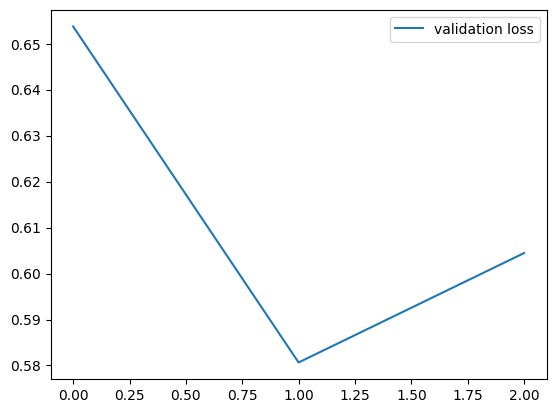

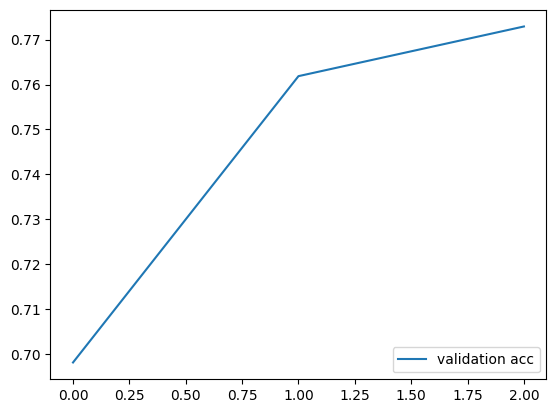

In [32]:
acc11 = []
for i in range(0, len(acc1)):
  acc11.append(acc1[i]['accuracy'])

plt.plot(loss1)
plt.legend(["validation loss"], loc ="upper right")
plt.show()

plt.plot(acc11)
plt.legend(["validation acc"], loc ="lower right")
plt.show()

In [33]:
trainer.evaluate(test_dataset)

/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


{'eval_loss': 0.5368449091911316,
 'eval_accuracy': 0.7934782608695652,
 'eval_runtime': 12.9273,
 'eval_samples_per_second': 120.984,
 'eval_steps_per_second': 7.581,
 'epoch': 3.0}

In [34]:
pred = trainer.predict(test_dataset)
print( classification_report( pred.label_ids , pred.predictions.argmax(-1) , labels=[0, 1, 2]) )

/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.81      0.82      0.81       519
           1       0.71      0.67      0.69       510
           2       0.86      0.89      0.87       535

    accuracy                           0.79      1564
   macro avg       0.79      0.79      0.79      1564
weighted avg       0.79      0.79      0.79      1564



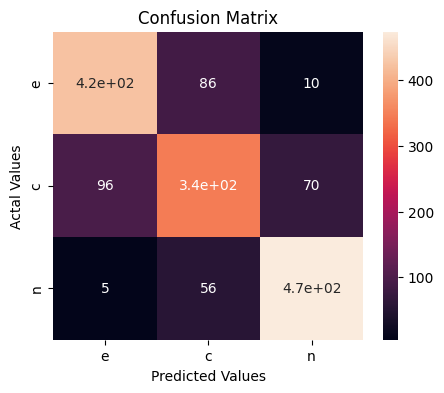

In [37]:
cm = confusion_matrix(pred.label_ids, pred.predictions.argmax(-1))
cm_df = pd.DataFrame(cm,
                     index = ['e','c','n'],
                     columns = ['e','c','n'])
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

# **Freezing first 9 layers**

In [46]:
config = AutoConfig.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")
model_f1 = AutoModelForSequenceClassification.from_pretrained("HooshvareLab/bert-base-parsbert-uncased", num_labels=3)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/bert-base-parsbert-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [47]:
for name, param in model_f1.named_parameters():
  if name.startswith("bert.encoder.layer.0"):
    param.requires_grad = False
  if name.startswith("bert.encoder.layer.1"):
    param.requires_grad = False
  if name.startswith("bert.encoder.layer.2"):
    param.requires_grad = False
  if name.startswith("bert.encoder.layer.3"):
    param.requires_grad = False
  if name.startswith("bert.encoder.layer.4"):
    param.requires_grad = False
  if name.startswith("bert.encoder.layer.5"):
    param.requires_grad = False
  if name.startswith("bert.encoder.layer.6"):
    param.requires_grad = False
  if name.startswith("bert.encoder.layer.7"):
    param.requires_grad = False
  if name.startswith("bert.encoder.layer.8"):
    param.requires_grad = False
  if name.startswith("bert.encoder.layer.9"):
    param.requires_grad = True
  if name.startswith("bert.encoder.layer.10"):
    param.requires_grad = True
  if name.startswith("bert.encoder.layer.11"):
    param.requires_grad = True

for name, param in model_f1.named_parameters():
     print(name, param.requires_grad)

bert.embeddings.word_embeddings.weight True
bert.embeddings.position_embeddings.weight True
bert.embeddings.token_type_embeddings.weight True
bert.embeddings.LayerNorm.weight True
bert.embeddings.LayerNorm.bias True
bert.encoder.layer.0.attention.self.query.weight False
bert.encoder.layer.0.attention.self.query.bias False
bert.encoder.layer.0.attention.self.key.weight False
bert.encoder.layer.0.attention.self.key.bias False
bert.encoder.layer.0.attention.self.value.weight False
bert.encoder.layer.0.attention.self.value.bias False
bert.encoder.layer.0.attention.output.dense.weight False
bert.encoder.layer.0.attention.output.dense.bias False
bert.encoder.layer.0.attention.output.LayerNorm.weight False
bert.encoder.layer.0.attention.output.LayerNorm.bias False
bert.encoder.layer.0.intermediate.dense.weight False
bert.encoder.layer.0.intermediate.dense.bias False
bert.encoder.layer.0.output.dense.weight False
bert.encoder.layer.0.output.dense.bias False
bert.encoder.layer.0.output.LayerNor

In [48]:
print(model_f1)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(100000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [49]:
acc2 = []
loss2 = []
def compute_metrics(eval_pred):
    global acc2
    global loss2
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    metric = load_metric("accuracy")
    acc2.append(metric.compute(predictions=predictions, references=labels))
    loss_fct = CrossEntropyLoss()
    loss = loss_fct(torch.tensor(logits).view(-1, 3), torch.tensor(labels).view(-1))
    loss2.append(loss)
    return metric.compute(predictions=predictions, references=labels)

training_args = TrainingArguments(
    output_dir                  = "./result_f1",
    per_device_train_batch_size = 16,
    per_device_eval_batch_size  = 16,
    num_train_epochs            = 6,
    learning_rate               = 0.00001,
    gradient_accumulation_steps = 1,
    overwrite_output_dir        = True,
    save_strategy               = "epoch",
    evaluation_strategy         = "epoch",
    load_best_model_at_end      = True,
    metric_for_best_model       = "accuracy",
)

trainer = Trainer(
    model           = model_f1,
    args            = training_args,
    train_dataset   = train_dataset,
    eval_dataset    = valid_dataset,
    tokenizer       = tokenizer,
    compute_metrics = compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.788306,0.627196
2,0.928900,0.660258,0.709174
3,0.713900,0.602757,0.759271
4,0.590000,0.588067,0.776187
5,0.528900,0.600701,0.775537
6,0.472000,0.604262,0.772934


/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric 

TrainOutput(global_step=2730, training_loss=0.6312607649918441, metrics={'train_runtime': 1040.9354, 'train_samples_per_second': 41.882, 'train_steps_per_second': 2.623, 'total_flos': 3440624190442740.0, 'train_loss': 0.6312607649918441, 'epoch': 6.0})

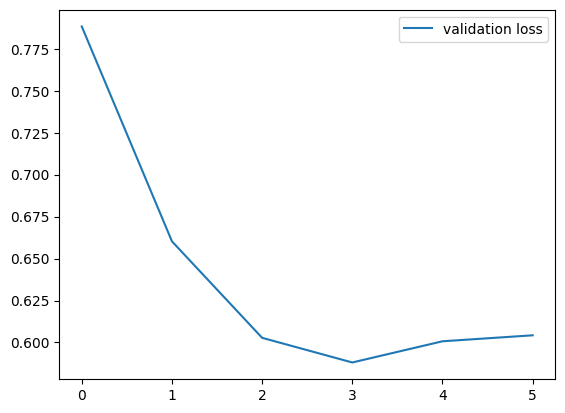

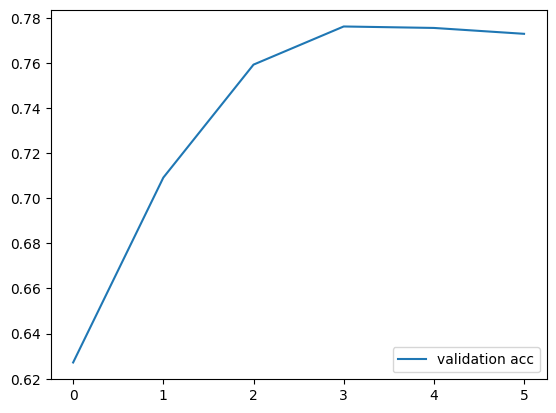

In [50]:
acc22 = []
for i in range(0, len(acc2)):
  acc22.append(acc2[i]['accuracy'])

plt.plot(loss2)
plt.legend(["validation loss"], loc ="upper right")
plt.show()

plt.plot(acc22)
plt.legend(["validation acc"], loc ="lower right")
plt.show()

In [51]:
trainer.evaluate(test_dataset)

/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


{'eval_loss': 0.5660070180892944,
 'eval_accuracy': 0.7736572890025576,
 'eval_runtime': 13.0997,
 'eval_samples_per_second': 119.392,
 'eval_steps_per_second': 7.481,
 'epoch': 6.0}

In [52]:
pred = trainer.predict(test_dataset)
print( classification_report( pred.label_ids , pred.predictions.argmax(-1) , labels=[0, 1, 2]) )

/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.75      0.82      0.79       519
           1       0.71      0.65      0.67       510
           2       0.86      0.85      0.85       535

    accuracy                           0.77      1564
   macro avg       0.77      0.77      0.77      1564
weighted avg       0.77      0.77      0.77      1564



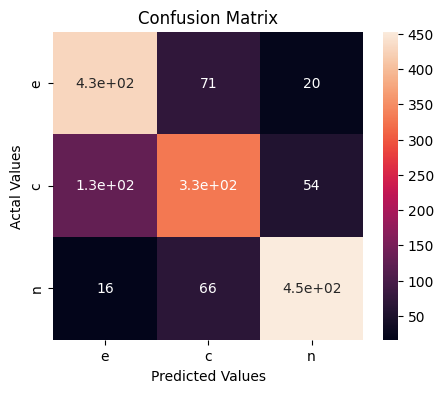

In [53]:
cm = confusion_matrix(pred.label_ids, pred.predictions.argmax(-1))
cm_df = pd.DataFrame(cm,
                     index = ['e','c','n'],
                     columns = ['e','c','n'])
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

# **Freezing all layers but last and embeddings**

In [55]:
config = AutoConfig.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")
model_f2 = AutoModelForSequenceClassification.from_pretrained("HooshvareLab/bert-base-parsbert-uncased", num_labels=3)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/bert-base-parsbert-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [56]:
for name, param in model_f2.named_parameters():
  if name.startswith("bert.encoder.layer.0"):
    param.requires_grad = False
  if name.startswith("bert.encoder.layer.1"):
    param.requires_grad = False
  if name.startswith("bert.encoder.layer.2"):
    param.requires_grad = False
  if name.startswith("bert.encoder.layer.3"):
    param.requires_grad = False
  if name.startswith("bert.encoder.layer.4"):
    param.requires_grad = False
  if name.startswith("bert.encoder.layer.5"):
    param.requires_grad = False
  if name.startswith("bert.encoder.layer.6"):
    param.requires_grad = False
  if name.startswith("bert.encoder.layer.7"):
    param.requires_grad = False
  if name.startswith("bert.encoder.layer.8"):
    param.requires_grad = False
  if name.startswith("bert.encoder.layer.9"):
    param.requires_grad = False
  if name.startswith("bert.encoder.layer.10"):
    param.requires_grad = False
  if name.startswith("bert.encoder.layer.11"):
    param.requires_grad = True

for name, param in model_f2.named_parameters():
     print(name, param.requires_grad)

bert.embeddings.word_embeddings.weight True
bert.embeddings.position_embeddings.weight True
bert.embeddings.token_type_embeddings.weight True
bert.embeddings.LayerNorm.weight True
bert.embeddings.LayerNorm.bias True
bert.encoder.layer.0.attention.self.query.weight False
bert.encoder.layer.0.attention.self.query.bias False
bert.encoder.layer.0.attention.self.key.weight False
bert.encoder.layer.0.attention.self.key.bias False
bert.encoder.layer.0.attention.self.value.weight False
bert.encoder.layer.0.attention.self.value.bias False
bert.encoder.layer.0.attention.output.dense.weight False
bert.encoder.layer.0.attention.output.dense.bias False
bert.encoder.layer.0.attention.output.LayerNorm.weight False
bert.encoder.layer.0.attention.output.LayerNorm.bias False
bert.encoder.layer.0.intermediate.dense.weight False
bert.encoder.layer.0.intermediate.dense.bias False
bert.encoder.layer.0.output.dense.weight False
bert.encoder.layer.0.output.dense.bias False
bert.encoder.layer.0.output.LayerNor

In [57]:
print(model_f2)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(100000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [58]:
acc3 = []
loss3 = []
def compute_metrics(eval_pred):
    global acc3
    global loss3
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    metric = load_metric("accuracy")
    acc3.append(metric.compute(predictions=predictions, references=labels))
    loss_fct = CrossEntropyLoss()
    loss = loss_fct(torch.tensor(logits).view(-1, 3), torch.tensor(labels).view(-1))
    loss3.append(loss)
    return metric.compute(predictions=predictions, references=labels)

training_args = TrainingArguments(
    output_dir                  = "./result_f2",
    per_device_train_batch_size = 16,
    per_device_eval_batch_size  = 16,
    num_train_epochs            = 6,
    learning_rate               = 0.00001,
    gradient_accumulation_steps = 1,
    overwrite_output_dir        = True,
    save_strategy               = "epoch",
    evaluation_strategy         = "epoch",
    load_best_model_at_end      = True,
    metric_for_best_model       = "accuracy",
)

trainer = Trainer(
    model           = model_f2,
    args            = training_args,
    train_dataset   = train_dataset,
    eval_dataset    = valid_dataset,
    tokenizer       = tokenizer,
    compute_metrics = compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.904101,0.543266
2,1.005900,0.838241,0.592062
3,0.857900,0.803791,0.600520
4,0.775800,0.788169,0.618087
5,0.740600,0.789396,0.623292
6,0.699800,0.795654,0.618087


/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric 

TrainOutput(global_step=2730, training_loss=0.8057547824286716, metrics={'train_runtime': 993.4203, 'train_samples_per_second': 43.885, 'train_steps_per_second': 2.748, 'total_flos': 3440624190442740.0, 'train_loss': 0.8057547824286716, 'epoch': 6.0})

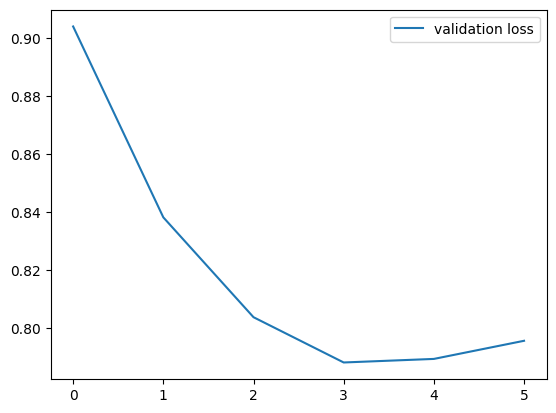

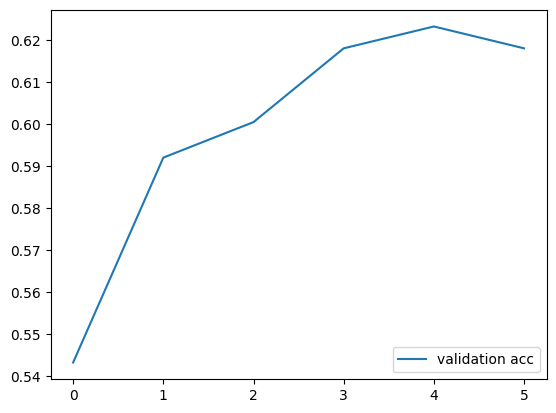

In [59]:
acc33 = []
for i in range(0, len(acc3)):
  acc33.append(acc3[i]['accuracy'])

plt.plot(loss3)
plt.legend(["validation loss"], loc ="upper right")
plt.show()

plt.plot(acc33)
plt.legend(["validation acc"], loc ="lower right")
plt.show()

In [60]:
trainer.evaluate(test_dataset)

/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


{'eval_loss': 0.7646322846412659,
 'eval_accuracy': 0.6425831202046036,
 'eval_runtime': 13.025,
 'eval_samples_per_second': 120.077,
 'eval_steps_per_second': 7.524,
 'epoch': 6.0}

In [61]:
pred = trainer.predict(test_dataset)
print( classification_report( pred.label_ids , pred.predictions.argmax(-1) , labels=[0, 1, 2]) )

/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.57      0.82      0.67       519
           1       0.54      0.36      0.43       510
           2       0.82      0.74      0.78       535

    accuracy                           0.64      1564
   macro avg       0.65      0.64      0.63      1564
weighted avg       0.65      0.64      0.63      1564



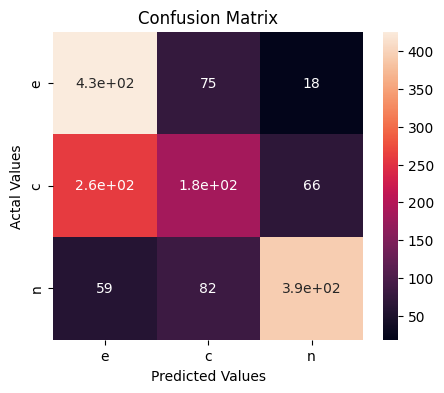

In [62]:
cm = confusion_matrix(pred.label_ids, pred.predictions.argmax(-1))
cm_df = pd.DataFrame(cm,
                     index = ['e','c','n'],
                     columns = ['e','c','n'])
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

# **Deleting Layers & keeping first 9 layers**

In [63]:
config = AutoConfig.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")
model_d = AutoModelForSequenceClassification.from_pretrained("HooshvareLab/bert-base-parsbert-uncased", num_labels=3)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/bert-base-parsbert-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [64]:
def deleteEncodingLayers(model, num_layers_to_keep):  # must pass in the full bert model
    oldModuleList = model.bert.encoder.layer
    newModuleList = nn.ModuleList()

    # Now iterate over all layers, only keepign only the relevant layers.
    for i in range(0, (num_layers_to_keep)):
        newModuleList.append(oldModuleList[i])

    # create a copy of the model, modify it with the new list, and return
    copyOfModel = copy.deepcopy(model)
    copyOfModel.bert.encoder.layer = newModuleList

    return copyOfModel

In [65]:
model_d = deleteEncodingLayers(model_d, 9)

for name, param in model_d.named_parameters():
     print(name, param.requires_grad)

bert.embeddings.word_embeddings.weight True
bert.embeddings.position_embeddings.weight True
bert.embeddings.token_type_embeddings.weight True
bert.embeddings.LayerNorm.weight True
bert.embeddings.LayerNorm.bias True
bert.encoder.layer.0.attention.self.query.weight True
bert.encoder.layer.0.attention.self.query.bias True
bert.encoder.layer.0.attention.self.key.weight True
bert.encoder.layer.0.attention.self.key.bias True
bert.encoder.layer.0.attention.self.value.weight True
bert.encoder.layer.0.attention.self.value.bias True
bert.encoder.layer.0.attention.output.dense.weight True
bert.encoder.layer.0.attention.output.dense.bias True
bert.encoder.layer.0.attention.output.LayerNorm.weight True
bert.encoder.layer.0.attention.output.LayerNorm.bias True
bert.encoder.layer.0.intermediate.dense.weight True
bert.encoder.layer.0.intermediate.dense.bias True
bert.encoder.layer.0.output.dense.weight True
bert.encoder.layer.0.output.dense.bias True
bert.encoder.layer.0.output.LayerNorm.weight True


In [66]:
print(model_d)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(100000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-8): 9 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, 

In [67]:
acc4 = []
loss4 = []
def compute_metrics(eval_pred):
    global acc4
    global loss4
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    metric = load_metric("accuracy")
    acc4.append(metric.compute(predictions=predictions, references=labels))
    loss_fct = CrossEntropyLoss()
    loss = loss_fct(torch.tensor(logits).view(-1, 3), torch.tensor(labels).view(-1))
    loss4.append(loss)
    return metric.compute(predictions=predictions, references=labels)

training_args = TrainingArguments(
    output_dir                  = "./result_fd",
    per_device_train_batch_size = 16,
    per_device_eval_batch_size  = 16,
    num_train_epochs            = 3,
    learning_rate               = 0.00001,
    gradient_accumulation_steps = 1,
    overwrite_output_dir        = True,
    save_strategy               = "epoch",
    evaluation_strategy         = "epoch",
    load_best_model_at_end      = True,
    metric_for_best_model       = "accuracy",

)

trainer = Trainer(
    model           = model_d,
    args            = training_args,
    train_dataset   = train_dataset,
    eval_dataset    = valid_dataset,
    tokenizer       = tokenizer,
    compute_metrics = compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.641894,0.706571
2,0.785200,0.603335,0.742355
3,0.532200,0.628913,0.748861


/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric 

TrainOutput(global_step=1365, training_loss=0.5935538938193967, metrics={'train_runtime': 516.8742, 'train_samples_per_second': 42.173, 'train_steps_per_second': 2.641, 'total_flos': 1293450372490392.0, 'train_loss': 0.5935538938193967, 'epoch': 3.0})

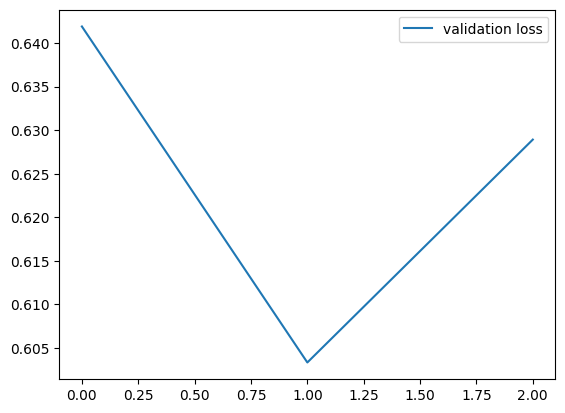

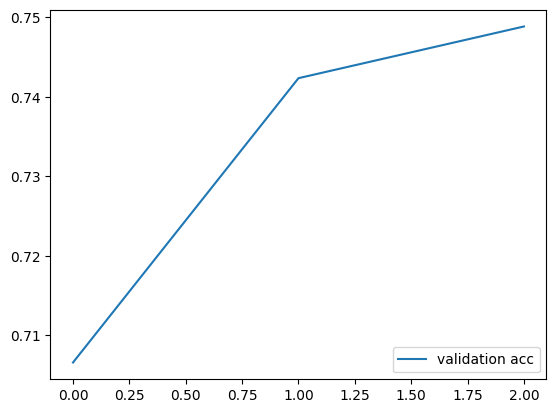

In [68]:
acc44 = []
for i in range(0, len(acc4)):
  acc44.append(acc4[i]['accuracy'])

plt.plot(loss4)
plt.legend(["validation loss"], loc ="upper right")
plt.show()

plt.plot(acc44)
plt.legend(["validation acc"], loc ="lower right")
plt.show()

In [69]:
trainer.evaluate(test_dataset)

/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


{'eval_loss': 0.5483962893486023,
 'eval_accuracy': 0.7800511508951407,
 'eval_runtime': 9.9819,
 'eval_samples_per_second': 156.683,
 'eval_steps_per_second': 9.818,
 'epoch': 3.0}

In [70]:
pred = trainer.predict(test_dataset)
print( classification_report( pred.label_ids , pred.predictions.argmax(-1) , labels=[0, 1, 2]) )

/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.78      0.83      0.80       519
           1       0.70      0.63      0.66       510
           2       0.85      0.88      0.86       535

    accuracy                           0.78      1564
   macro avg       0.78      0.78      0.78      1564
weighted avg       0.78      0.78      0.78      1564



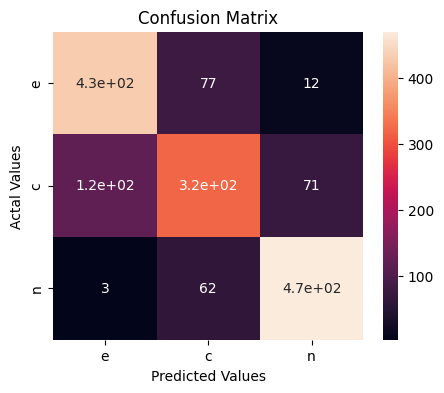

In [71]:
cm = confusion_matrix(pred.label_ids, pred.predictions.argmax(-1))
cm_df = pd.DataFrame(cm,
                     index = ['e','c','n'],
                     columns = ['e','c','n'])
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

# **Deleting Attention Head**

In [72]:
config = AutoConfig.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")
model_da = AutoModelForSequenceClassification.from_pretrained("HooshvareLab/bert-base-parsbert-uncased", num_labels=3)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/bert-base-parsbert-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [73]:
print(model_da)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(100000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [74]:
# Calculate the number of attention heads to prune (50% of total heads)
total_heads = model_da.config.num_attention_heads
heads_to_prune = int(0.5 * total_heads)
# Create a list of all attention heads
all_heads = list(range(total_heads))
# Shuffle the list randomly
random.shuffle(all_heads)
# Select the heads to be pruned
heads_to_prune_list = all_heads[:heads_to_prune]

# Create the dictionary for heads to be pruned in each layer
heads_mask = {layer: heads_to_prune_list for layer in range(model_da.config.num_hidden_layers)}

# Prune heads in each layer
model_da.prune_heads(heads_mask)

# Display model summary after pruning
print(model_da)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(100000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=384, bias=True)
              (key): Linear(in_features=768, out_features=384, bias=True)
              (value): Linear(in_features=768, out_features=384, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=384, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [75]:
acc5 = []
loss5 = []
def compute_metrics(eval_pred):
    global acc5
    global loss5
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    metric = load_metric("accuracy")
    acc5.append(metric.compute(predictions=predictions, references=labels))
    loss_fct = CrossEntropyLoss()
    loss = loss_fct(torch.tensor(logits).view(-1, 3), torch.tensor(labels).view(-1))
    loss5.append(loss)
    return metric.compute(predictions=predictions, references=labels)

training_args = TrainingArguments(
    output_dir                  = "./result_ahd",
    per_device_train_batch_size = 16,
    per_device_eval_batch_size  = 16,
    num_train_epochs            = 6,
    learning_rate               = 0.00001,
    gradient_accumulation_steps = 1,
    overwrite_output_dir        = True,
    save_strategy               = "epoch",
    evaluation_strategy         = "epoch",
    load_best_model_at_end      = True,
    metric_for_best_model       = "accuracy",

)

trainer = Trainer(
    model           = model_da,
    args            = training_args,
    train_dataset   = train_dataset,
    eval_dataset    = valid_dataset,
    tokenizer       = tokenizer,
    compute_metrics = compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.673511,0.699414
2,0.849700,0.623717,0.739753
3,0.563400,0.638143,0.755368
4,0.398700,0.709146,0.762524


/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric 

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.673511,0.699414
2,0.849700,0.623717,0.739753
3,0.563400,0.638143,0.755368
4,0.398700,0.709146,0.762524
5,0.306700,0.802148,0.755368
6,0.229800,0.828655,0.769681


/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric 

TrainOutput(global_step=2730, training_loss=0.4474039070772164, metrics={'train_runtime': 1109.4056, 'train_samples_per_second': 39.297, 'train_steps_per_second': 2.461, 'total_flos': 2871413504746740.0, 'train_loss': 0.4474039070772164, 'epoch': 6.0})

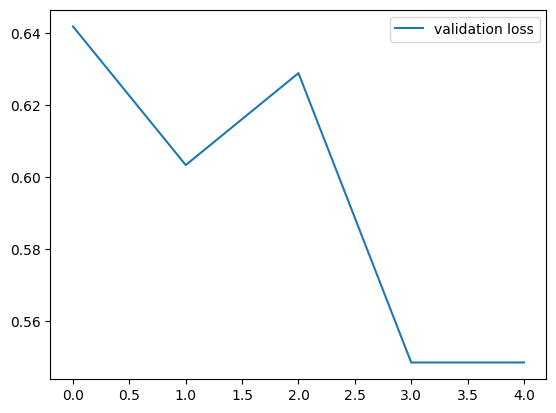

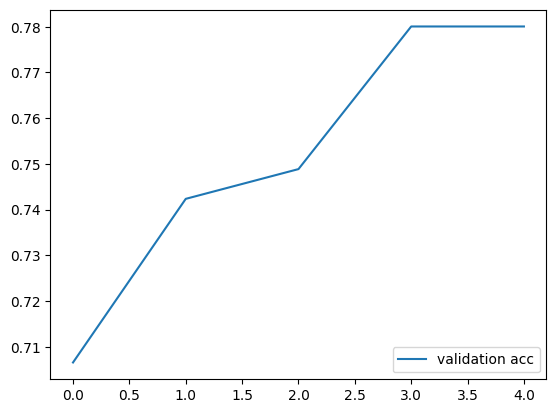

In [76]:
acc55 = []
for i in range(0, len(acc4)):
  acc55.append(acc4[i]['accuracy'])

plt.plot(loss4)
plt.legend(["validation loss"], loc ="upper right")
plt.show()

plt.plot(acc55)
plt.legend(["validation acc"], loc ="lower right")
plt.show()

In [77]:
trainer.evaluate(test_dataset)

/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


{'eval_loss': 0.7612638473510742,
 'eval_accuracy': 0.7787723785166241,
 'eval_runtime': 10.8542,
 'eval_samples_per_second': 144.091,
 'eval_steps_per_second': 9.029,
 'epoch': 6.0}

In [78]:
pred = trainer.predict(test_dataset)
print( classification_report( pred.label_ids , pred.predictions.argmax(-1) , labels=[0, 1, 2]) )

/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.78      0.83      0.80       519
           1       0.69      0.67      0.68       510
           2       0.86      0.84      0.85       535

    accuracy                           0.78      1564
   macro avg       0.78      0.78      0.78      1564
weighted avg       0.78      0.78      0.78      1564



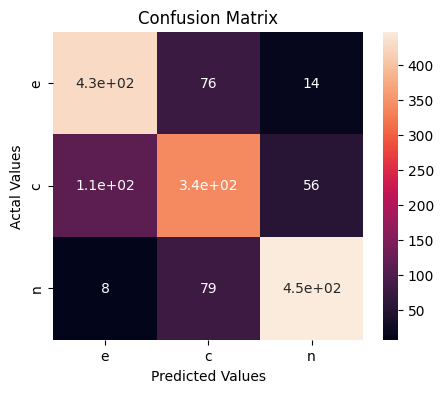

In [79]:
cm = confusion_matrix(pred.label_ids, pred.predictions.argmax(-1))
cm_df = pd.DataFrame(cm,
                     index = ['e','c','n'],
                     columns = ['e','c','n'])
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()